<a href="https://colab.research.google.com/github/MyNameIsEldar/Movie_Recommender/blob/main/Picture_Finding_System_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Picture Finding System Demo


## Project Info

Поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

В файле train_dataset.csv собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке train_images содержатся изображения для тренировки модели.

В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
Имя файла изображения.
Идентификатор описания.

Доля людей, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание не соответствует изображению.

В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
Имя файла изображения.
Идентификатор описания.
3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке test_images содержатся изображения для тестирования модели.

## Imports

In [129]:
!pip install transformers

In [130]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torch import nn
from PIL import Image
from tqdm import tqdm

from torch.utils.data import DataLoader, TensorDataset
from torchvision.io import read_image
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.models import resnet50
from transformers import AutoTokenizer, BertTokenizer, BertModel

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

## Downloading Data

In [131]:
!wget https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip

--2023-07-14 10:03:07--  https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150987455 (144M) [application/zip]
Saving to: ‘dsplus_integrated_project_4.zip.1’

dsplus_integrated_p 100%[===================>] 143.99M  19.9MB/s    in 8.2s    

2023-07-14 10:03:16 (17.5 MB/s) - ‘dsplus_integrated_project_4.zip.1’ saved [150987455/150987455]



In [132]:
!unzip dsplus_integrated_project_4.zip

Archive:  dsplus_integrated_project_4.zip
replace to_upload/test_images.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [133]:
PATH = '/content/to_upload/'
TRAIN_IM_PATH = '/content/to_upload/train_images'
TEST_IM_PATH = '/content/to_upload/test_images'

## EDA

Посмотрим на все данные, которые предложены для работы

In [134]:
crowd_annotations = pd.read_table(PATH + 'CrowdAnnotations.tsv', header = None)
expert_annotations = pd.read_table(PATH + 'ExpertAnnotations.tsv', header = None)
test_images = pd.read_csv(PATH + 'test_images.csv')
train_dataset = pd.read_csv(PATH + 'train_dataset.csv')
test_queries = pd.read_csv(PATH + 'test_queries.csv', error_bad_lines=False)

<ipython-input-134-6931bb63e18f>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test_queries = pd.read_csv(PATH + 'test_queries.csv', error_bad_lines=False)
Skipping line 73: expected 3 fields, saw 4



In [135]:
dataframes = [crowd_annotations, expert_annotations, test_images, train_dataset, test_queries]

for df in dataframes:
  print()
  display(df.head())

0                            1    2  3  4
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.0  3  0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.0  0  3
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.0  0  3
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.0  0  3
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.0  0  3

0                            1  2  3  4
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  1  2  2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  1  1  2

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

|query_id|query_text|image
0|1177994172_10d143cb8d.jpg#0|Two blonde boys       one in a camouflage shirt and the other in blue    are having a water fight .|1177994172_10d143c...
1|1177994172_10d143cb8d.jpg#1|Two boys are squi... NaN                                                                                              NaN
2|1177994172_10d143cb8d.jpg#2|Two boys spraying... NaN                                                                                              NaN
3|1177994172_10d143cb8d.jpg#3|Two children wear... NaN                                                                                              NaN
4|1177994172_10d143cb8d.jpg#4|Two young boys ar... NaN                                                                                              NaN

Сразу видно, что есть ошибка с выводом `test_queries`. Поправим сепарацию

In [136]:
test_queries = pd.read_csv(PATH + 'test_queries.csv', sep='|', index_col=0)
test_queries

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
3    Two children wearing jeans squirt water at eac...   
4    Two young boys are squirting water at each oth...   
..                                                 ...   
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                         image  
0    1177994172_10d143cb8d.jpg  
1    1177994172_10d143cb8d.jpg  
2    1177994172_10d143cb8d.jpg  
3    1177994172_10d143cb8d.jpg  
4    1177994172_10d143cb8d.jpg  
..                         ...  
495   989851184_9ef368e520.jpg  
496   989851184_9ef368e520.jpg  
497   989851184_9ef368e520.jpg  
498   989851184_9ef368e520.jpg  
499   989851184_9ef368e520.jpg  

[500 rows x 3 columns]

Теперь все предельно ясно и понятно, все на месте.

In [137]:
for df in dataframes:
  display(df.info())
  print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 499 entries, ('0|1177994172_10d143cb8d.jpg#0|Two blonde boys ', ' one in a camouflage shirt and the other in blue ') to ('499|989851184_9ef368e520.jpg#4|The black dog has a toy in its mouth and a person stands nearby .|989851184_9ef368e520.jpg', nan)
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   |query_id|query_text|image  7 non-null      object
dtypes: object(1)
memory usage: 26.7+ KB


None

### Annotations

Посмотрим на оценки запросов

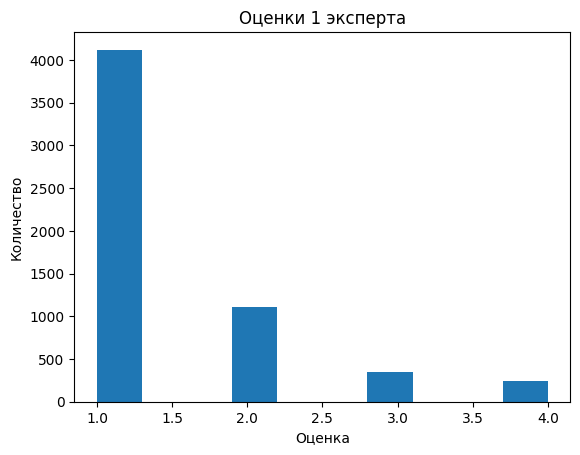

In [138]:
plt.hist(expert_annotations[2])
plt.title('Оценки 1 эксперта')
plt.ylabel('Количество')
plt.xlabel('Оценка')
plt.show()

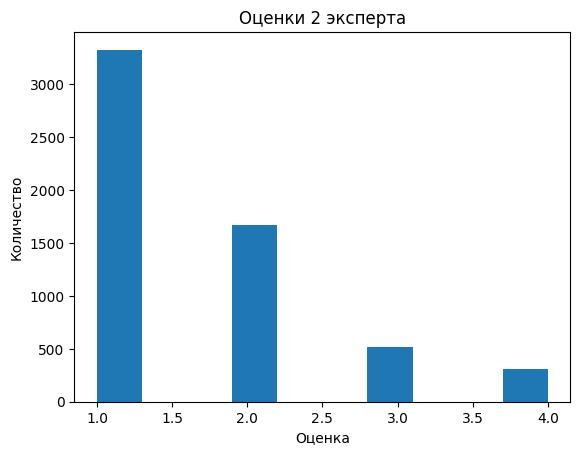

In [139]:
plt.hist(expert_annotations[3])
plt.title('Оценки 2 эксперта')
plt.ylabel('Количество')
plt.xlabel('Оценка')
plt.show()

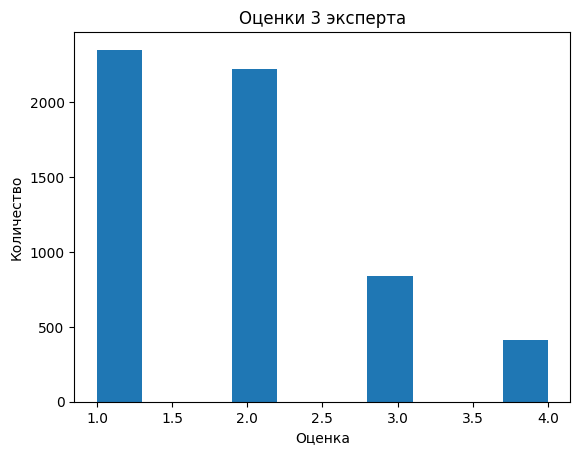

In [140]:
plt.hist(expert_annotations[4])
plt.title('Оценки 3 эксперта')
plt.ylabel('Количество')
plt.xlabel('Оценка')
plt.show()

По графикам можно сделать вывод о том, что куда больше неподходящий запросов, чем подходящих. Так же эксперты проранжировались по критичности оценки от наиболее критичного к менее критичному

Теперь посмотрим на оценки, полученные на краудсорсе. Здесь будем смотреть на процент, т.к. это наиболее репрезентативный параметр в данном датафрейме для анализа

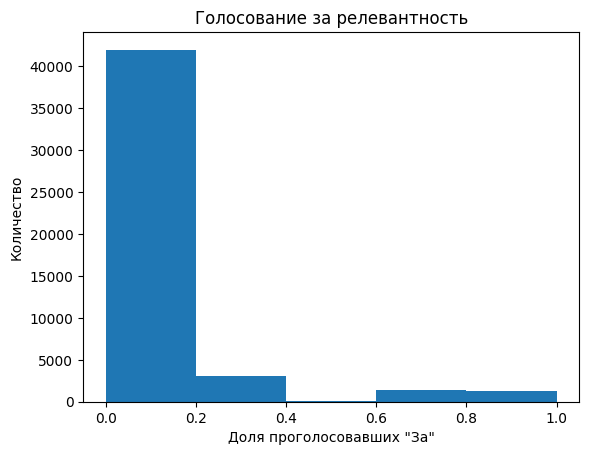

In [141]:
plt.hist(crowd_annotations[2], bins=5)
plt.title('Голосование за релевантность')
plt.ylabel('Количество')
plt.xlabel('Доля проголосовавших "За"')
plt.show()

Предположение, о том, что нерелевантных запросов куда больше релевантных подтвердилось. Много нулей в долях.

Изучим, сколько проголосовавших всего есть. Для этого посмотрим на столбец `0`

In [142]:
crowd_annotations[4].value_counts().sort_index()

0     1323
1     1371
2     3034
3    41219
4      665
5      176
6       42
Name: 4, dtype: int64

Стало ясно, что голосовавших не так много

Опишем процесс формирование таргета. Для более полного описания результатов оценки запросов будем использовать как оценки экспертов, так краудсорса.

Данные по экспертам преобразуем следующим образом. Возьмем среднее по оценкам трех экспертов, а затем поделим на 4. Таким образом мы получим значения от 0 до 1.

Затем сложим крауд и экспертов, заранее домножив на 0.3 и 0.7 соответсвенно. Таким образом мнение экспертов будет иметь больший вес чем крауд.

In [143]:
expert_annotations['mean_norm'] = expert_annotations[[2, 3, 4]].sum(axis=1) / 3 / 4

In [144]:
expert_annotations

0                            1  2  3  4  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1   
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2   
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2   
3     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  1  2  2   
4     1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  1  1  2   
...                         ...                          ... .. .. ..   
5817   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2  1  1  1   
5818   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2  1  1  1   
5819   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2  1  1  2   
5820   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2  1  1  1   
5821   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2  3  3  3   

      mean_norm  
0      0.250000  
1      0.333333  
2      0.333333  
3      0.416667  
4      0.333333  
...         ...  
5817   0.250000  
5818   0.250000  
5819   0.333333  
5820   0.250000  
5821   0.750000  

[5822 rows x 6 columns]

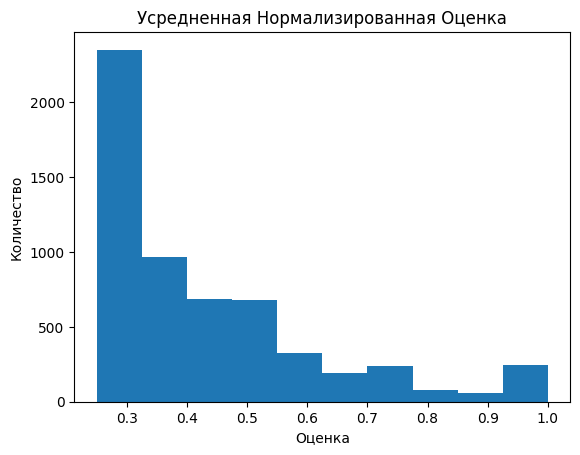

In [145]:
plt.hist(expert_annotations['mean_norm'])
plt.title('Усредненная Нормализированная Оценка')
plt.ylabel('Количество')
plt.xlabel('Оценка')
plt.show()

Запишем итоговыый таргет в тренировочный датасет

In [146]:
final_train_dataset = pd.merge(train_dataset, expert_annotations[[0, 1, 'mean_norm']], left_on=['image', 'query_id'], right_on=[0, 1])
final_train_dataset.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  \
0  A young child is wearing blue goggles and sitt...   
1  A young child is wearing blue goggles and sitt...   
2  A young child is wearing blue goggles and sitt...   
3  A young child is wearing blue goggles and sitt...   
4  A young child is wearing blue goggles and sitt...   

                           0                            1  mean_norm  
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   0.250000  
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   0.250000  
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   0.416667  
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   1.000000  
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   0.250000

In [147]:
final_train_dataset = pd.merge(final_train_dataset, crowd_annotations[[0, 1, 2]], left_on=['image', 'query_id'], right_on=[0, 1])
final_train_dataset.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  \
0  A young child is wearing blue goggles and sitt...   
1  A young child is wearing blue goggles and sitt...   
2  A young child is wearing blue goggles and sitt...   
3  A young child is wearing blue goggles and sitt...   
4  A young child is wearing blue goggles and sitt...   

                         0_x                          1_x  mean_norm  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   0.250000   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   0.416667   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   1.000000   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   0.583333   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   0.250000   

                         0_y                          1_y    2  
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  0.0  
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2  0.0  
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2  1.0  
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2  0.0  
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2  0.0

In [148]:
final_train_dataset['target'] = final_train_dataset['mean_norm'] * 0.7 + final_train_dataset[2] * 0.3
final_train_dataset = final_train_dataset[['image', 'query_id', 'query_text', 'target']]
final_train_dataset.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text    target  
0  A young child is wearing blue goggles and sitt...  0.175000  
1  A young child is wearing blue goggles and sitt...  0.291667  
2  A young child is wearing blue goggles and sitt...  1.000000  
3  A young child is wearing blue goggles and sitt...  0.408333  
4  A young child is wearing blue goggles and sitt...  0.175000

In [149]:
final_train_dataset.tail()

image                     query_id  \
2324  476759700_8911f087f8.jpg  1082379191_ec1e53f996.jpg#2   
2325  561417861_8e25d0c0e8.jpg   410453140_5401bf659a.jpg#2   
2326  561940436_64d6fc125d.jpg  3157847991_463e006a28.jpg#2   
2327  757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
2328  929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   

                                             query_text    target  
2324              A man and a woman sitting on a dock .  0.233333  
2325  A man stands at the entrance of Yerba Buena Ce...  0.350000  
2326  Two men in black jackets behind a white handra...  0.233333  
2327         A man in an ampitheater talking to a boy .  0.508333  
2328                       A blurry photo of two dogs .  0.466667

## Data Cleaning

In [150]:
stop_words = [
    'kid',
    'child',
    'boy',
    'girl',
    'baby',
    'teen',
    'young',
    'newborn'
]

In [151]:
def find_stop_words(row):
  for word in stop_words:
    if word in row['query_text'].lower():
      return 1
  return 0

Применим фукнцию для того, чтобы понять, в каких описаниях есть стоп слова.

In [152]:
final_train_dataset['is_wrong'] = final_train_dataset.apply(find_stop_words, axis=1)
final_train_dataset.head()

<ipython-input-152-7fe558fb8450>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train_dataset['is_wrong'] = final_train_dataset.apply(find_stop_words, axis=1)


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text    target  is_wrong  
0  A young child is wearing blue goggles and sitt...  0.175000         1  
1  A young child is wearing blue goggles and sitt...  0.291667         1  
2  A young child is wearing blue goggles and sitt...  1.000000         1  
3  A young child is wearing blue goggles and sitt...  0.408333         1  
4  A young child is wearing blue goggles and sitt...  0.175000         1

In [153]:
final_train_dataset.tail()

image                     query_id  \
2324  476759700_8911f087f8.jpg  1082379191_ec1e53f996.jpg#2   
2325  561417861_8e25d0c0e8.jpg   410453140_5401bf659a.jpg#2   
2326  561940436_64d6fc125d.jpg  3157847991_463e006a28.jpg#2   
2327  757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
2328  929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   

                                             query_text    target  is_wrong  
2324              A man and a woman sitting on a dock .  0.233333         0  
2325  A man stands at the entrance of Yerba Buena Ce...  0.350000         0  
2326  Two men in black jackets behind a white handra...  0.233333         0  
2327         A man in an ampitheater talking to a boy .  0.508333         1  
2328                       A blurry photo of two dogs .  0.466667         0

In [154]:
final_train_dataset.sample(5)

image                     query_id  \
1527  3217187564_0ffd89dec1.jpg  2968182121_b3b491df85.jpg#2   
1116  3642220260_3aa8a52670.jpg  1772859261_236c09b861.jpg#2   
1166  1561658940_a947f2446a.jpg  3627011534_485f667b10.jpg#2   
1916  3655155990_b0e201dd3c.jpg  2541104331_a2d65cfa54.jpg#2   
2120  2718495608_d8533e3ac5.jpg  3655074079_7df3812bc5.jpg#2   

                                             query_text    target  is_wrong  
1527                              Two greyhounds race .  0.625000         0  
1116                 A dog splashes through the water .  0.566667         0  
1166  A young girl is wearing a purple shirt and pin...  0.525000         1  
1916                     a dog pounces into the water .  0.625000         0  
2120  A naked woman wearing body paint riding a bicy...  0.291667         0

Теперь стоит удалить те картинки, для которых таргет 1 и `is_wrong` 1.
Это будут те картинки, для которых совпало описание, в котором есть синонимы слова child и их части.

Стоит обратить внимание на то, что этот подход достаточно тривиален и не будет работать в частных случаях. Например, если в описании картинки не сказано про детей, но они все же присутствуют (если ребенок попал на второй план изображения). Более правильным с точки зрения точности решения проблемы будет подход, при котором для чистки используются не только описания картинок, но и сами картинки. Можно было бы использовать модель, обученную на детекцию класса детей на изображении.

Так же для обработки описаний можно было бы использовать не просто чистку по части запрещенных слов, а полноценную модель. Например, можно было бы использовать предобученные на задачу QuestionAnswering модели и трансформеры.
Они могли бы помочь в тех ситуациях когда, наличие ребенка не описано явно ("маленький человек", в значении "ребенок").

Тогда вероятность того, что после чистки останутся данные, которые нельзя использовать уменьшится. Однако в нашем проекте рассматривается другая задача. Поэтому оставим реализованный подход и оставим упоминание о том, что это не единственный способ очистить данные)

In [155]:
final_train_dataset['target_rounded'] = final_train_dataset['target'].astype(float).round()

In [156]:
final_train_dataset = final_train_dataset.loc[(final_train_dataset['target_rounded'] + final_train_dataset['is_wrong']) < 2]

In [157]:
final_train_dataset.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   
5  3741827382_71e93298d0.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text    target  is_wrong  \
0  A young child is wearing blue goggles and sitt...  0.175000         1   
1  A young child is wearing blue goggles and sitt...  0.291667         1   
3  A young child is wearing blue goggles and sitt...  0.408333         1   
4  A young child is wearing blue goggles and sitt...  0.175000         1   
5  A young child is wearing blue goggles and sitt...  0.350000         1   

   target_rounded  
0             0.0  
1             0.0  
3             0.0  
4             0.0  
5             0.0

Не забудем о тестовом датасете. Тут достаточно будет обозначить те строки, которые нам не подходят и удалить их.

In [158]:
test_queries['is_wrong'] = test_queries.apply(find_stop_words, axis=1)

In [159]:
test_queries = test_queries.loc[test_queries['is_wrong'] == 0]
test_queries.head()

query_id  \
11   123997871_6a9ca987b1.jpg#1   
13   123997871_6a9ca987b1.jpg#3   
14   123997871_6a9ca987b1.jpg#4   
15  1319634306_816f21677f.jpg#0   
16  1319634306_816f21677f.jpg#1   

                                           query_text  \
11  Several female lacrosse players are going afte...   
13  The woman lacrosse player in blue is about to ...   
14                              Women play lacrosse .   
15        A brown dog is sitting in some long grass .   
16             A brown dog sits still on a hillside .   

                        image  is_wrong  
11   123997871_6a9ca987b1.jpg         0  
13   123997871_6a9ca987b1.jpg         0  
14   123997871_6a9ca987b1.jpg         0  
15  1319634306_816f21677f.jpg         0  
16  1319634306_816f21677f.jpg         0

In [160]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327 entries, 11 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    327 non-null    object
 1   query_text  327 non-null    object
 2   image       327 non-null    object
 3   is_wrong    327 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 12.8+ KB


После чистки осталось всего 327 фото

## Image Vectorization

Приступим к веторизации картинок. Будем использовать предобученную модель ResNet50, инициализировать будем веса ImageNet. Т.к. нам нужно получить только векторное представление, то линейный слой из модели уберем.

In [161]:
resnet_model = resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [162]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Теперь уберем последний слой

In [163]:
resnet_model = nn.Sequential(*(list(resnet_model.children())[:-1]))
resnet_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [164]:
resnet_model.to('cuda')
resnet_model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Загрузим изображения текст

In [165]:
final_train_dataset.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   
5  3741827382_71e93298d0.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text    target  is_wrong  \
0  A young child is wearing blue goggles and sitt...  0.175000         1   
1  A young child is wearing blue goggles and sitt...  0.291667         1   
3  A young child is wearing blue goggles and sitt...  0.408333         1   
4  A young child is wearing blue goggles and sitt...  0.175000         1   
5  A young child is wearing blue goggles and sitt...  0.350000         1   

   target_rounded  
0             0.0  
1             0.0  
3             0.0  
4             0.0  
5             0.0

In [166]:
final_train_dataset.image

0       1056338697_4f7d7ce270.jpg
1       2447284966_d6bbdb4b6e.jpg
3       3030566410_393c36a6c5.jpg
4       3718964174_cb2dc1615e.jpg
5       3741827382_71e93298d0.jpg
                  ...            
2323     444481722_690d0cadcf.jpg
2324     476759700_8911f087f8.jpg
2325     561417861_8e25d0c0e8.jpg
2326     561940436_64d6fc125d.jpg
2328     929679367_ff8c7df2ee.jpg
Name: image, Length: 2211, dtype: object

In [167]:
transform = transforms.Compose([transforms.Resize(224),
                                 transforms.ToTensor()])

In [168]:
def train_images_to_vec(image_path):
  image = Image.open(TRAIN_IM_PATH + '/' + image_path).convert('RGB')
  image = transform(image)
  with torch.no_grad():
    image = resnet_model(image.to('cuda').unsqueeze(0))
  image = image.flatten().to('cpu')
  return image.numpy()

In [169]:
tqdm.pandas()
train_image_vectors = final_train_dataset['image'].progress_apply(train_images_to_vec)
train_image_vectors

100%|██████████| 2211/2211 [00:35<00:00, 62.56it/s]


0       [0.08834454, 0.31814983, 0.43366498, 0.3651692...
1       [0.48852623, 1.0082433, 0.18654163, 0.29012877...
3       [0.21591239, 0.5411522, 0.8238766, 1.1129537, ...
4       [0.3503969, 0.5708665, 1.533107, 0.04112771, 0...
5       [0.22926211, 0.48320544, 0.50504214, 0.2199328...
                              ...                        
2323    [0.19381233, 0.83563834, 0.89284605, 0.1905669...
2324    [0.11385174, 1.6038069, 0.6625584, 0.16457613,...
2325    [0.30484423, 0.59677035, 0.7887511, 0.62985426...
2326    [0.30725327, 0.596273, 0.7690562, 0.15498365, ...
2328    [0.34617883, 0.5773609, 1.0711677, 0.17800088,...
Name: image, Length: 2211, dtype: object

In [170]:
train_image_vectors.shape

(2211,)

In [171]:
train_image_vectors = np.array(train_image_vectors)

In [172]:
train_image_vectors.shape

(2211,)

In [173]:
pretrained = 'bert-base-uncased'

In [174]:
tokenizer = BertTokenizer.from_pretrained(pretrained)

In [175]:
bert_model = BertModel.from_pretrained(pretrained)
bert_model.to('cuda')
bert_model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [176]:
tokenized_texts = final_train_dataset['query_text'].progress_apply(tokenizer, truncation=True,
                          padding="max_length",
                          max_length=25,
                          return_tensors="pt").values

100%|██████████| 2211/2211 [00:01<00:00, 1685.64it/s]


In [177]:
with torch.no_grad():
  torch.cuda.empty_cache()
with torch.no_grad():
  train_query_vectors = np.array([bert_model(**tokenized_texts[i].to('cuda')) for i in tqdm(range(len(tokenized_texts)))])

100%|██████████| 2211/2211 [00:24<00:00, 89.31it/s]


Помотрим, как выглядит вывод модели для одного запроса

In [319]:
train_query_vectors[5]

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 3.0646e-01,  1.8740e-01, -3.1748e-01,  ..., -1.9276e-01,
           1.8112e-01,  5.7759e-01],
         [ 2.7737e-01, -2.2400e-01, -7.1288e-01,  ..., -1.8458e-01,
           2.0467e-02,  2.6872e-01],
         [ 3.0596e-01, -1.0687e+00, -3.5441e-01,  ..., -2.6509e-01,
          -2.7549e-01,  4.0387e-02],
         ...,
         [ 1.9966e-01, -1.2970e-01,  1.3907e-01,  ..., -3.5385e-04,
          -1.1748e-01,  4.2052e-02],
         [ 3.5982e-01,  3.5598e-02,  2.6712e-01,  ..., -1.8873e-02,
          -7.1427e-02,  9.0465e-02],
         [-1.9052e-01, -3.4186e-01,  3.0168e-02,  ...,  9.1001e-02,
           3.3905e-01, -2.7051e-01]]], device='cuda:0'), pooler_output=tensor([[-0.8634, -0.5801, -0.9694,  0.6043,  0.8911, -0.2952,  0.8389,  0.4438,
         -0.8267, -1.0000, -0.5103,  0.9817,  0.9846,  0.5914,  0.9304, -0.7139,
         -0.3719, -0.5787,  0.3400, -0.3775,  0.7118,  1.0000, -0.2011,  0.3439,
          0.5399

In [449]:
train_query_vectors[1][1].shape

torch.Size([1, 768])

В last_hidden_state находятся тензоры, описывающие скрытое состояние на последнем слое для каждого токена. pooler_output описывает скрытое состояние для первого токена ([CLS]), к которму дополнительно применяется tanh фукнция активации.

Для того, чтобы получить необходимый нам вектор признаков достаточно использовать только вектор [CLS] токена, в котором зашита информация о всей поледовательности.

In [450]:
train_query_vectors[1][1].shape

torch.Size([1, 768])

In [451]:
train_query = np.array([train_query_vectors[i][1].flatten().to('cpu').detach().numpy() for i in range(len(train_query_vectors))])
train_query.shape

(2211, 768)

Теперь создадим общий вектор признаков. Выделим таргеты

In [452]:
X = np.array([np.concatenate((train_query[i], train_image_vectors[i])) for i in range(len(train_query))])
X.shape

(2211, 2816)

Сразу определим `input_size`

In [549]:
input_size = 2816

In [550]:
y = final_train_dataset.target.to_numpy()
y.shape

(2211,)

Разобьем на тестовую и валидационную выборки

In [551]:
gss = GroupShuffleSplit(n_splits=len(final_train_dataset.image.value_counts()), test_size=0.3)

In [552]:
a, b = next(gss.split(X=X, y=y, groups=final_train_dataset.image))

In [553]:
train_index, val_index = next(gss.split(X=X, y=y, groups=final_train_dataset.image))

In [554]:
X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]

In [555]:
X_train.shape

(1528, 2816)

Данные загружены и отвекторизированы. Размер каждого ветора признаков известен. Сделали его стандартным для правильной работы моделей. Теперь перейдем к обучению моделей.

## Models

В качестве моделей будем использовать обыкновенную линейную регрессию, градиенный бустинг и полносвязную нейронную сеть.

Со структурой нейронной сети определимся сразу, будем использвать общепринятый универсальный апроксиматор: 3 полносвязных слоя. В последнем слое - один нейрон.

Начнем с линейной регрессии

В качестве целевой метрики будем использовать `RMSE`. Наша цель - дать процент соответствия запроса картинке. Т.к. метрика - `RMSE`, то loss-функцией будет `MSE`. Задачу можно было бы перевести в вид бинарной классификации и выдавать не класс, а подобие вероятности, которое каждая модель отдает до того, как ответ преобразуется в вид 0 или 1, но остановимся на регрессии, т.к. так наше предсказание будет больше соответствовать мнению экспертов/крауда.

In [515]:
models_results = pd.DataFrame(columns=['linear_regression', 'gradient_boosting', 'FCNN'], index=['RMSE'])

### Linear Regression

In [516]:
linear_regression = LinearRegression()

In [517]:
linear_regression.fit(X_train, y_train)

LinearRegression()

In [518]:
reg_preds = linear_regression.predict(X_val)

In [519]:
mean_squared_error(y_val, reg_preds, squared=False)

0.6185603583624534

In [520]:
models_results['linear_regression'] = mean_squared_error(y_val, reg_preds, squared=False)

Выводы сделаем позже, а пока градиентный бустинг

### Gradient Boosting

In [521]:
gb = GradientBoostingRegressor(verbose=1)

In [522]:
gb.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0561            1.79m
         2           0.0541            2.62m
         3           0.0523            3.68m
         4           0.0507            3.63m
         5           0.0493            3.22m
         6           0.0481            2.93m
         7           0.0469            2.72m
         8           0.0457            2.56m
         9           0.0447            2.43m
        10           0.0437            2.32m
        20           0.0362            1.80m
        30           0.0315            1.51m
        40           0.0277            1.27m
        50           0.0253            1.04m
        60           0.0229           49.69s
        70           0.0212           36.88s
        80           0.0200           24.33s
        90           0.0182           12.14s
       100           0.0170            0.00s


GradientBoostingRegressor(verbose=1)

In [523]:
gb_preds = gb.predict(X_val)

In [524]:
mean_squared_error(y_val, gb_preds, squared=False)

0.22428099261798856

In [525]:
models_results['gradient_boosting'] = mean_squared_error(y_val, gb_preds, squared=False)

### Neural Network

In [556]:
with torch.no_grad():
  torch.cuda.empty_cache()

In [557]:
X_train_tensor, y_train_tensor = torch.tensor(X_train).type(torch.float32).to('cuda'), torch.tensor(y_train).type(torch.float32 ).to('cuda')
X_val_tensor, y_val_tensor = torch.tensor(X_val).type(torch.float32).to('cuda'), torch.tensor(y_val).type(torch.float32 ).to('cuda')

In [558]:
train_tensor_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_tensor_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_tensor_dataloader = DataLoader(train_tensor_dataset,
                                     batch_size=32,
                                     shuffle=True)

val_tensor_dataloader = DataLoader(val_tensor_dataset,
                                     batch_size=32,
                                     shuffle=True)

In [559]:
class NeuralNet(nn.Module):
    """NN with 3 hidden layers, PReLu activations, with regularization"""

    def __init__(self, input_size,
                 hidden_size_1,
                 hidden_size_2,
                 hidden_size_3):
        super(NeuralNet, self).__init__()
        self.relu = nn.ReLU()
        self.prelu = nn.PReLU()
        self.dc = nn.Dropout(p=.3)
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.bc1 = nn.BatchNorm1d(hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.bc2 = nn.BatchNorm1d(hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.bc3 = nn.BatchNorm1d(hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_3, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bc1(out)
        out = self.prelu(out)
        out = self.fc2(out)
        out = self.bc2(out)
        out = self.prelu(out)
        out = self.fc3(out)
        out = self.bc3(out)
        out = self.prelu(out)
        out = self.fc4(out)
        out = self.relu(out)
        return out

In [560]:
FCNN = NeuralNet(input_size, 3000, 1000, 1)

learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(FCNN.parameters(), lr=learning_rate)

In [561]:
def model_training(model, train_loader, val_loader, num_epochs):
  total_step = len(train_loader)
  rmse_vals = []
  for epoch in tqdm(range(num_epochs)):
      model.train()
      for i, (X, y) in enumerate(train_loader):

          # Прямой проход
          outputs = model(X).flatten()
          loss = criterion(outputs, y)

          # Обратный проход
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          if (i+1) % 25 == 0:
              rmse = mean_squared_error(y.cpu().detach().numpy(), outputs.cpu().detach().numpy(), squared=False)
              print ('Эпоха [{}/{}], Итерация [{}/{}], Значение функции потерь: {:.4f} RMSE: {}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item(),
                            rmse))
              rmse_vals.append(rmse)

  plt.figure(figsize=(8,8))
  plt.plot(range(num_epochs), rmse_vals)
  plt.title('Neural Net Training Process')
  plt.xlabel('Epoch')
  plt.ylabel('Rmse')
  plt.show()

In [562]:
FCNN.to('cuda')

NeuralNet(
  (relu): ReLU()
  (prelu): PReLU(num_parameters=1)
  (dc): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=2816, out_features=3000, bias=True)
  (bc1): BatchNorm1d(3000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=3000, out_features=1000, bias=True)
  (bc2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1000, out_features=1, bias=True)
  (bc3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1, out_features=1, bias=True)
)

  1%|          | 1/150 [00:00<00:32,  4.55it/s]

Эпоха [1/150], Итерация [25/48], Значение функции потерь: 0.1364 RMSE: 0.369320809841156


  1%|▏         | 2/150 [00:00<00:34,  4.24it/s]

Эпоха [2/150], Итерация [25/48], Значение функции потерь: 0.0985 RMSE: 0.3138850927352905


  2%|▏         | 3/150 [00:00<00:34,  4.28it/s]

Эпоха [3/150], Итерация [25/48], Значение функции потерь: 0.0746 RMSE: 0.27311015129089355


  3%|▎         | 4/150 [00:00<00:33,  4.34it/s]

Эпоха [4/150], Итерация [25/48], Значение функции потерь: 0.0499 RMSE: 0.22329318523406982


  3%|▎         | 5/150 [00:01<00:33,  4.32it/s]

Эпоха [5/150], Итерация [25/48], Значение функции потерь: 0.0813 RMSE: 0.2851884961128235


  4%|▍         | 6/150 [00:01<00:33,  4.34it/s]

Эпоха [6/150], Итерация [25/48], Значение функции потерь: 0.0434 RMSE: 0.20826858282089233


  5%|▍         | 7/150 [00:01<00:33,  4.32it/s]

Эпоха [7/150], Итерация [25/48], Значение функции потерь: 0.0405 RMSE: 0.20130044221878052


  5%|▌         | 8/150 [00:01<00:32,  4.35it/s]

Эпоха [8/150], Итерация [25/48], Значение функции потерь: 0.0371 RMSE: 0.19254930317401886


  6%|▌         | 9/150 [00:02<00:32,  4.33it/s]

Эпоха [9/150], Итерация [25/48], Значение функции потерь: 0.0390 RMSE: 0.19747385382652283


  7%|▋         | 10/150 [00:02<00:32,  4.29it/s]

Эпоха [10/150], Итерация [25/48], Значение функции потерь: 0.0258 RMSE: 0.16060781478881836


  7%|▋         | 11/150 [00:02<00:32,  4.34it/s]

Эпоха [11/150], Итерация [25/48], Значение функции потерь: 0.0329 RMSE: 0.18146373331546783


  8%|▊         | 12/150 [00:02<00:31,  4.35it/s]

Эпоха [12/150], Итерация [25/48], Значение функции потерь: 0.0467 RMSE: 0.216147318482399


  9%|▊         | 13/150 [00:03<00:31,  4.33it/s]

Эпоха [13/150], Итерация [25/48], Значение функции потерь: 0.0232 RMSE: 0.15220202505588531


  9%|▉         | 14/150 [00:03<00:31,  4.34it/s]

Эпоха [14/150], Итерация [25/48], Значение функции потерь: 0.0233 RMSE: 0.15275681018829346


 10%|█         | 15/150 [00:03<00:31,  4.27it/s]

Эпоха [15/150], Итерация [25/48], Значение функции потерь: 0.0439 RMSE: 0.20959971845149994


 11%|█         | 16/150 [00:03<00:31,  4.29it/s]

Эпоха [16/150], Итерация [25/48], Значение функции потерь: 0.0255 RMSE: 0.15977632999420166


 11%|█▏        | 17/150 [00:03<00:30,  4.34it/s]

Эпоха [17/150], Итерация [25/48], Значение функции потерь: 0.0314 RMSE: 0.1772509515285492


 12%|█▏        | 18/150 [00:04<00:30,  4.33it/s]

Эпоха [18/150], Итерация [25/48], Значение функции потерь: 0.0389 RMSE: 0.1972770392894745


 13%|█▎        | 19/150 [00:04<00:30,  4.32it/s]

Эпоха [19/150], Итерация [25/48], Значение функции потерь: 0.0255 RMSE: 0.1596384346485138


 13%|█▎        | 20/150 [00:04<00:30,  4.32it/s]

Эпоха [20/150], Итерация [25/48], Значение функции потерь: 0.0230 RMSE: 0.1516287475824356


 14%|█▍        | 21/150 [00:04<00:29,  4.34it/s]

Эпоха [21/150], Итерация [25/48], Значение функции потерь: 0.0253 RMSE: 0.1589377522468567


 15%|█▍        | 22/150 [00:05<00:29,  4.34it/s]

Эпоха [22/150], Итерация [25/48], Значение функции потерь: 0.0344 RMSE: 0.18534794449806213


 15%|█▌        | 23/150 [00:05<00:29,  4.29it/s]

Эпоха [23/150], Итерация [25/48], Значение функции потерь: 0.0240 RMSE: 0.15481576323509216


 16%|█▌        | 24/150 [00:05<00:29,  4.30it/s]

Эпоха [24/150], Итерация [25/48], Значение функции потерь: 0.0217 RMSE: 0.14746920764446259


 17%|█▋        | 25/150 [00:05<00:28,  4.35it/s]

Эпоха [25/150], Итерация [25/48], Значение функции потерь: 0.0433 RMSE: 0.20807653665542603


 17%|█▋        | 26/150 [00:06<00:28,  4.31it/s]

Эпоха [26/150], Итерация [25/48], Значение функции потерь: 0.0221 RMSE: 0.14856192469596863


 18%|█▊        | 27/150 [00:06<00:28,  4.33it/s]

Эпоха [27/150], Итерация [25/48], Значение функции потерь: 0.0163 RMSE: 0.12751223146915436


 19%|█▊        | 28/150 [00:06<00:28,  4.27it/s]

Эпоха [28/150], Итерация [25/48], Значение функции потерь: 0.0180 RMSE: 0.13413499295711517


 19%|█▉        | 29/150 [00:06<00:27,  4.35it/s]

Эпоха [29/150], Итерация [25/48], Значение функции потерь: 0.0202 RMSE: 0.1421167403459549


 20%|██        | 30/150 [00:06<00:27,  4.36it/s]

Эпоха [30/150], Итерация [25/48], Значение функции потерь: 0.0387 RMSE: 0.19664517045021057


 21%|██        | 31/150 [00:07<00:27,  4.34it/s]

Эпоха [31/150], Итерация [25/48], Значение функции потерь: 0.0210 RMSE: 0.1448524296283722


 21%|██▏       | 32/150 [00:07<00:27,  4.29it/s]

Эпоха [32/150], Итерация [25/48], Значение функции потерь: 0.0209 RMSE: 0.1444275826215744


 22%|██▏       | 33/150 [00:07<00:26,  4.36it/s]

Эпоха [33/150], Итерация [25/48], Значение функции потерь: 0.0230 RMSE: 0.15168865025043488


 23%|██▎       | 34/150 [00:07<00:26,  4.32it/s]

Эпоха [34/150], Итерация [25/48], Значение функции потерь: 0.0168 RMSE: 0.1297854334115982


 23%|██▎       | 35/150 [00:08<00:27,  4.14it/s]

Эпоха [35/150], Итерация [25/48], Значение функции потерь: 0.0114 RMSE: 0.10676123946905136


 24%|██▍       | 36/150 [00:08<00:27,  4.22it/s]

Эпоха [36/150], Итерация [25/48], Значение функции потерь: 0.0142 RMSE: 0.11913084238767624


 25%|██▍       | 37/150 [00:08<00:26,  4.27it/s]

Эпоха [37/150], Итерация [25/48], Значение функции потерь: 0.0203 RMSE: 0.1426188200712204


 25%|██▌       | 38/150 [00:08<00:26,  4.27it/s]

Эпоха [38/150], Итерация [25/48], Значение функции потерь: 0.0216 RMSE: 0.14682261645793915


 26%|██▌       | 39/150 [00:09<00:25,  4.30it/s]

Эпоха [39/150], Итерация [25/48], Значение функции потерь: 0.0244 RMSE: 0.1561780422925949


 27%|██▋       | 40/150 [00:09<00:25,  4.31it/s]

Эпоха [40/150], Итерация [25/48], Значение функции потерь: 0.0146 RMSE: 0.12086166441440582


 27%|██▋       | 41/150 [00:09<00:25,  4.25it/s]

Эпоха [41/150], Итерация [25/48], Значение функции потерь: 0.0129 RMSE: 0.1135714128613472


 28%|██▊       | 42/150 [00:09<00:25,  4.31it/s]

Эпоха [42/150], Итерация [25/48], Значение функции потерь: 0.0112 RMSE: 0.10581666231155396


 29%|██▊       | 43/150 [00:09<00:24,  4.28it/s]

Эпоха [43/150], Итерация [25/48], Значение функции потерь: 0.0181 RMSE: 0.13444216549396515


 29%|██▉       | 44/150 [00:10<00:24,  4.27it/s]

Эпоха [44/150], Итерация [25/48], Значение функции потерь: 0.0143 RMSE: 0.11948388069868088


 30%|███       | 45/150 [00:10<00:24,  4.25it/s]

Эпоха [45/150], Итерация [25/48], Значение функции потерь: 0.0131 RMSE: 0.11440997570753098


 31%|███       | 46/150 [00:10<00:24,  4.23it/s]

Эпоха [46/150], Итерация [25/48], Значение функции потерь: 0.0201 RMSE: 0.14183232188224792


 31%|███▏      | 47/150 [00:10<00:24,  4.24it/s]

Эпоха [47/150], Итерация [25/48], Значение функции потерь: 0.0111 RMSE: 0.10535748302936554


 32%|███▏      | 48/150 [00:11<00:24,  4.24it/s]

Эпоха [48/150], Итерация [25/48], Значение функции потерь: 0.0099 RMSE: 0.09951329976320267


 33%|███▎      | 49/150 [00:11<00:23,  4.23it/s]

Эпоха [49/150], Итерация [25/48], Значение функции потерь: 0.0209 RMSE: 0.14463607966899872


 33%|███▎      | 50/150 [00:11<00:23,  4.23it/s]

Эпоха [50/150], Итерация [25/48], Значение функции потерь: 0.0251 RMSE: 0.15837152302265167


 34%|███▍      | 51/150 [00:11<00:23,  4.29it/s]

Эпоха [51/150], Итерация [25/48], Значение функции потерь: 0.0265 RMSE: 0.16275499761104584


 35%|███▍      | 52/150 [00:12<00:22,  4.45it/s]

Эпоха [52/150], Итерация [25/48], Значение функции потерь: 0.0108 RMSE: 0.10389897972345352


 35%|███▌      | 53/150 [00:12<00:21,  4.44it/s]

Эпоха [53/150], Итерация [25/48], Значение функции потерь: 0.0126 RMSE: 0.11229033023118973


 36%|███▌      | 54/150 [00:12<00:21,  4.38it/s]

Эпоха [54/150], Итерация [25/48], Значение функции потерь: 0.0094 RMSE: 0.09697380661964417


 37%|███▋      | 55/150 [00:12<00:21,  4.37it/s]

Эпоха [55/150], Итерация [25/48], Значение функции потерь: 0.0218 RMSE: 0.14777667820453644


 37%|███▋      | 56/150 [00:12<00:21,  4.35it/s]

Эпоха [56/150], Итерация [25/48], Значение функции потерь: 0.0117 RMSE: 0.10808942466974258


 38%|███▊      | 57/150 [00:13<00:21,  4.35it/s]

Эпоха [57/150], Итерация [25/48], Значение функции потерь: 0.0156 RMSE: 0.12480349838733673


 39%|███▊      | 58/150 [00:13<00:21,  4.33it/s]

Эпоха [58/150], Итерация [25/48], Значение функции потерь: 0.0179 RMSE: 0.1338614523410797


 39%|███▉      | 59/150 [00:13<00:20,  4.34it/s]

Эпоха [59/150], Итерация [25/48], Значение функции потерь: 0.0074 RMSE: 0.08607348054647446


 40%|████      | 60/150 [00:13<00:20,  4.32it/s]

Эпоха [60/150], Итерация [25/48], Значение функции потерь: 0.0087 RMSE: 0.09351324290037155


 41%|████      | 61/150 [00:14<00:20,  4.33it/s]

Эпоха [61/150], Итерация [25/48], Значение функции потерь: 0.0101 RMSE: 0.10045890510082245


 41%|████▏     | 62/150 [00:14<00:20,  4.33it/s]

Эпоха [62/150], Итерация [25/48], Значение функции потерь: 0.0195 RMSE: 0.13955192267894745


 42%|████▏     | 63/150 [00:14<00:20,  4.21it/s]

Эпоха [63/150], Итерация [25/48], Значение функции потерь: 0.0357 RMSE: 0.1888161301612854


 43%|████▎     | 64/150 [00:14<00:19,  4.33it/s]

Эпоха [64/150], Итерация [25/48], Значение функции потерь: 0.0186 RMSE: 0.13654036819934845


 43%|████▎     | 65/150 [00:15<00:19,  4.30it/s]

Эпоха [65/150], Итерация [25/48], Значение функции потерь: 0.0142 RMSE: 0.11916036158800125


 44%|████▍     | 66/150 [00:15<00:19,  4.31it/s]

Эпоха [66/150], Итерация [25/48], Значение функции потерь: 0.0137 RMSE: 0.1169762834906578


 45%|████▍     | 67/150 [00:15<00:19,  4.20it/s]

Эпоха [67/150], Итерация [25/48], Значение функции потерь: 0.0079 RMSE: 0.08900199830532074


 45%|████▌     | 68/150 [00:15<00:18,  4.39it/s]

Эпоха [68/150], Итерация [25/48], Значение функции потерь: 0.0120 RMSE: 0.10932160913944244


 46%|████▌     | 69/150 [00:16<00:18,  4.36it/s]

Эпоха [69/150], Итерация [25/48], Значение функции потерь: 0.0068 RMSE: 0.08275820314884186


 47%|████▋     | 70/150 [00:16<00:18,  4.36it/s]

Эпоха [70/150], Итерация [25/48], Значение функции потерь: 0.0209 RMSE: 0.14469406008720398


 47%|████▋     | 71/150 [00:16<00:18,  4.33it/s]

Эпоха [71/150], Итерация [25/48], Значение функции потерь: 0.0129 RMSE: 0.11336828768253326


 48%|████▊     | 72/150 [00:16<00:18,  4.28it/s]

Эпоха [72/150], Итерация [25/48], Значение функции потерь: 0.0153 RMSE: 0.1235099583864212


 49%|████▊     | 73/150 [00:16<00:17,  4.33it/s]

Эпоха [73/150], Итерация [25/48], Значение функции потерь: 0.0070 RMSE: 0.08365743607282639


 49%|████▉     | 74/150 [00:17<00:17,  4.30it/s]

Эпоха [74/150], Итерация [25/48], Значение функции потерь: 0.0114 RMSE: 0.10653677582740784


 50%|█████     | 75/150 [00:17<00:17,  4.33it/s]

Эпоха [75/150], Итерация [25/48], Значение функции потерь: 0.0079 RMSE: 0.08893948048353195


 51%|█████     | 76/150 [00:17<00:17,  4.31it/s]

Эпоха [76/150], Итерация [25/48], Значение функции потерь: 0.0080 RMSE: 0.08948389440774918


 51%|█████▏    | 77/150 [00:17<00:16,  4.34it/s]

Эпоха [77/150], Итерация [25/48], Значение функции потерь: 0.0070 RMSE: 0.08387582004070282


 52%|█████▏    | 78/150 [00:18<00:16,  4.29it/s]

Эпоха [78/150], Итерация [25/48], Значение функции потерь: 0.0045 RMSE: 0.06708057969808578


 53%|█████▎    | 79/150 [00:18<00:16,  4.29it/s]

Эпоха [79/150], Итерация [25/48], Значение функции потерь: 0.0131 RMSE: 0.11454059183597565


 53%|█████▎    | 80/150 [00:18<00:16,  4.32it/s]

Эпоха [80/150], Итерация [25/48], Значение функции потерь: 0.0235 RMSE: 0.15316075086593628


 54%|█████▍    | 81/150 [00:18<00:16,  4.30it/s]

Эпоха [81/150], Итерация [25/48], Значение функции потерь: 0.0057 RMSE: 0.07561401277780533


 55%|█████▍    | 82/150 [00:19<00:15,  4.34it/s]

Эпоха [82/150], Итерация [25/48], Значение функции потерь: 0.0167 RMSE: 0.1292766034603119


 55%|█████▌    | 83/150 [00:19<00:15,  4.34it/s]

Эпоха [83/150], Итерация [25/48], Значение функции потерь: 0.0219 RMSE: 0.14785520732402802


 56%|█████▌    | 84/150 [00:19<00:15,  4.33it/s]

Эпоха [84/150], Итерация [25/48], Значение функции потерь: 0.0107 RMSE: 0.10343805700540543


 57%|█████▋    | 85/150 [00:19<00:15,  4.29it/s]

Эпоха [85/150], Итерация [25/48], Значение функции потерь: 0.0188 RMSE: 0.13721993565559387


 57%|█████▋    | 86/150 [00:19<00:14,  4.35it/s]

Эпоха [86/150], Итерация [25/48], Значение функции потерь: 0.0079 RMSE: 0.08871592581272125


 58%|█████▊    | 87/150 [00:20<00:14,  4.35it/s]

Эпоха [87/150], Итерация [25/48], Значение функции потерь: 0.0057 RMSE: 0.07530958950519562


 59%|█████▊    | 88/150 [00:20<00:14,  4.34it/s]

Эпоха [88/150], Итерация [25/48], Значение функции потерь: 0.0061 RMSE: 0.07836834341287613


 59%|█████▉    | 89/150 [00:20<00:14,  4.32it/s]

Эпоха [89/150], Итерация [25/48], Значение функции потерь: 0.0101 RMSE: 0.10027018934488297


 60%|██████    | 90/150 [00:20<00:13,  4.32it/s]

Эпоха [90/150], Итерация [25/48], Значение функции потерь: 0.0179 RMSE: 0.1336510330438614


 61%|██████    | 91/150 [00:21<00:13,  4.31it/s]

Эпоха [91/150], Итерация [25/48], Значение функции потерь: 0.0120 RMSE: 0.10948212444782257


 61%|██████▏   | 92/150 [00:21<00:13,  4.33it/s]

Эпоха [92/150], Итерация [25/48], Значение функции потерь: 0.0144 RMSE: 0.11984219402074814


 62%|██████▏   | 93/150 [00:21<00:13,  4.33it/s]

Эпоха [93/150], Итерация [25/48], Значение функции потерь: 0.0084 RMSE: 0.09166425466537476


 63%|██████▎   | 94/150 [00:21<00:13,  4.28it/s]

Эпоха [94/150], Итерация [25/48], Значение функции потерь: 0.0092 RMSE: 0.09611352533102036


 63%|██████▎   | 95/150 [00:22<00:13,  4.18it/s]

Эпоха [95/150], Итерация [25/48], Значение функции потерь: 0.0119 RMSE: 0.10930431634187698


 64%|██████▍   | 96/150 [00:22<00:12,  4.23it/s]

Эпоха [96/150], Итерация [25/48], Значение функции потерь: 0.0063 RMSE: 0.07957139611244202


 65%|██████▍   | 97/150 [00:22<00:12,  4.26it/s]

Эпоха [97/150], Итерация [25/48], Значение функции потерь: 0.0181 RMSE: 0.13456875085830688


 65%|██████▌   | 98/150 [00:22<00:12,  4.30it/s]

Эпоха [98/150], Итерация [25/48], Значение функции потерь: 0.0346 RMSE: 0.18589383363723755


 66%|██████▌   | 99/150 [00:22<00:11,  4.27it/s]

Эпоха [99/150], Итерация [25/48], Значение функции потерь: 0.0099 RMSE: 0.09964194893836975


 67%|██████▋   | 100/150 [00:23<00:11,  4.32it/s]

Эпоха [100/150], Итерация [25/48], Значение функции потерь: 0.0144 RMSE: 0.12007059156894684


 67%|██████▋   | 101/150 [00:23<00:11,  4.30it/s]

Эпоха [101/150], Итерация [25/48], Значение функции потерь: 0.0143 RMSE: 0.1195717379450798


 68%|██████▊   | 102/150 [00:23<00:11,  4.30it/s]

Эпоха [102/150], Итерация [25/48], Значение функции потерь: 0.0060 RMSE: 0.07772894948720932


 69%|██████▊   | 103/150 [00:23<00:11,  4.22it/s]

Эпоха [103/150], Итерация [25/48], Значение функции потерь: 0.0065 RMSE: 0.08039489388465881


 69%|██████▉   | 104/150 [00:24<00:10,  4.26it/s]

Эпоха [104/150], Итерация [25/48], Значение функции потерь: 0.0127 RMSE: 0.11281020939350128


 70%|███████   | 105/150 [00:24<00:10,  4.20it/s]

Эпоха [105/150], Итерация [25/48], Значение функции потерь: 0.0075 RMSE: 0.08645197004079819


 71%|███████   | 106/150 [00:24<00:10,  4.23it/s]

Эпоха [106/150], Итерация [25/48], Значение функции потерь: 0.0106 RMSE: 0.1027500182390213


 71%|███████▏  | 107/150 [00:24<00:10,  4.25it/s]

Эпоха [107/150], Итерация [25/48], Значение функции потерь: 0.0199 RMSE: 0.1410600244998932


 72%|███████▏  | 108/150 [00:25<00:09,  4.26it/s]

Эпоха [108/150], Итерация [25/48], Значение функции потерь: 0.0042 RMSE: 0.06445960700511932


 73%|███████▎  | 109/150 [00:25<00:09,  4.25it/s]

Эпоха [109/150], Итерация [25/48], Значение функции потерь: 0.0097 RMSE: 0.0982716828584671


 73%|███████▎  | 110/150 [00:25<00:09,  4.21it/s]

Эпоха [110/150], Итерация [25/48], Значение функции потерь: 0.0153 RMSE: 0.12356039136648178


 74%|███████▍  | 111/150 [00:25<00:08,  4.36it/s]

Эпоха [111/150], Итерация [25/48], Значение функции потерь: 0.0037 RMSE: 0.0605972595512867


 75%|███████▍  | 112/150 [00:26<00:08,  4.41it/s]

Эпоха [112/150], Итерация [25/48], Значение функции потерь: 0.0105 RMSE: 0.10256016999483109


 75%|███████▌  | 113/150 [00:26<00:08,  4.36it/s]

Эпоха [113/150], Итерация [25/48], Значение функции потерь: 0.0037 RMSE: 0.06105632334947586


 76%|███████▌  | 114/150 [00:26<00:08,  4.33it/s]

Эпоха [114/150], Итерация [25/48], Значение функции потерь: 0.0047 RMSE: 0.06823499500751495


 77%|███████▋  | 115/150 [00:26<00:08,  4.33it/s]

Эпоха [115/150], Итерация [25/48], Значение функции потерь: 0.0052 RMSE: 0.07244179397821426


 77%|███████▋  | 116/150 [00:26<00:07,  4.29it/s]

Эпоха [116/150], Итерация [25/48], Значение функции потерь: 0.0057 RMSE: 0.07540549337863922


 78%|███████▊  | 117/150 [00:27<00:07,  4.33it/s]

Эпоха [117/150], Итерация [25/48], Значение функции потерь: 0.0156 RMSE: 0.12476474791765213


 79%|███████▊  | 118/150 [00:27<00:07,  4.34it/s]

Эпоха [118/150], Итерация [25/48], Значение функции потерь: 0.0060 RMSE: 0.07749336957931519


 79%|███████▉  | 119/150 [00:27<00:07,  4.30it/s]

Эпоха [119/150], Итерация [25/48], Значение функции потерь: 0.0081 RMSE: 0.08974482119083405


 80%|████████  | 120/150 [00:27<00:06,  4.35it/s]

Эпоха [120/150], Итерация [25/48], Значение функции потерь: 0.0059 RMSE: 0.0765712633728981


 81%|████████  | 121/150 [00:28<00:06,  4.34it/s]

Эпоха [121/150], Итерация [25/48], Значение функции потерь: 0.0092 RMSE: 0.0956844612956047


 81%|████████▏ | 122/150 [00:28<00:06,  4.33it/s]

Эпоха [122/150], Итерация [25/48], Значение функции потерь: 0.0048 RMSE: 0.06955155730247498


 82%|████████▏ | 123/150 [00:28<00:06,  4.32it/s]

Эпоха [123/150], Итерация [25/48], Значение функции потерь: 0.0106 RMSE: 0.10279625654220581


 83%|████████▎ | 124/150 [00:28<00:05,  4.35it/s]

Эпоха [124/150], Итерация [25/48], Значение функции потерь: 0.0070 RMSE: 0.08339622616767883


 83%|████████▎ | 125/150 [00:29<00:05,  4.33it/s]

Эпоха [125/150], Итерация [25/48], Значение функции потерь: 0.0061 RMSE: 0.07816052436828613


 84%|████████▍ | 126/150 [00:29<00:05,  4.32it/s]

Эпоха [126/150], Итерация [25/48], Значение функции потерь: 0.0143 RMSE: 0.11961407214403152


 85%|████████▍ | 127/150 [00:29<00:05,  4.32it/s]

Эпоха [127/150], Итерация [25/48], Значение функции потерь: 0.0081 RMSE: 0.09012626856565475


 85%|████████▌ | 128/150 [00:29<00:05,  4.33it/s]

Эпоха [128/150], Итерация [25/48], Значение функции потерь: 0.0027 RMSE: 0.05164385959506035


 86%|████████▌ | 129/150 [00:29<00:04,  4.29it/s]

Эпоха [129/150], Итерация [25/48], Значение функции потерь: 0.0081 RMSE: 0.08975555002689362


 87%|████████▋ | 130/150 [00:30<00:04,  4.33it/s]

Эпоха [130/150], Итерация [25/48], Значение функции потерь: 0.0058 RMSE: 0.07604607194662094


 87%|████████▋ | 131/150 [00:30<00:04,  4.33it/s]

Эпоха [131/150], Итерация [25/48], Значение функции потерь: 0.0104 RMSE: 0.10184574127197266


 88%|████████▊ | 132/150 [00:30<00:04,  4.34it/s]

Эпоха [132/150], Итерация [25/48], Значение функции потерь: 0.0090 RMSE: 0.09482105821371078


 89%|████████▊ | 133/150 [00:30<00:03,  4.34it/s]

Эпоха [133/150], Итерация [25/48], Значение функции потерь: 0.0106 RMSE: 0.1028691902756691


 89%|████████▉ | 134/150 [00:31<00:03,  4.33it/s]

Эпоха [134/150], Итерация [25/48], Значение функции потерь: 0.0046 RMSE: 0.06810265779495239


 90%|█████████ | 135/150 [00:31<00:03,  4.32it/s]

Эпоха [135/150], Итерация [25/48], Значение функции потерь: 0.0080 RMSE: 0.08951636403799057


 91%|█████████ | 136/150 [00:31<00:03,  4.32it/s]

Эпоха [136/150], Итерация [25/48], Значение функции потерь: 0.0127 RMSE: 0.11284081637859344


 91%|█████████▏| 137/150 [00:31<00:03,  4.33it/s]

Эпоха [137/150], Итерация [25/48], Значение функции потерь: 0.0038 RMSE: 0.061642322689294815


 92%|█████████▏| 138/150 [00:32<00:02,  4.29it/s]

Эпоха [138/150], Итерация [25/48], Значение функции потерь: 0.0035 RMSE: 0.058910924941301346


 93%|█████████▎| 139/150 [00:32<00:02,  4.33it/s]

Эпоха [139/150], Итерация [25/48], Значение функции потерь: 0.0117 RMSE: 0.10806964337825775


 93%|█████████▎| 140/150 [00:32<00:02,  4.30it/s]

Эпоха [140/150], Итерация [25/48], Значение функции потерь: 0.0130 RMSE: 0.11384980380535126


 94%|█████████▍| 141/150 [00:32<00:02,  4.32it/s]

Эпоха [141/150], Итерация [25/48], Значение функции потерь: 0.0044 RMSE: 0.06641640514135361


 95%|█████████▍| 142/150 [00:32<00:01,  4.32it/s]

Эпоха [142/150], Итерация [25/48], Значение функции потерь: 0.0284 RMSE: 0.1686522215604782


 95%|█████████▌| 143/150 [00:33<00:01,  4.28it/s]

Эпоха [143/150], Итерация [25/48], Значение функции потерь: 0.0138 RMSE: 0.11742392927408218


 96%|█████████▌| 144/150 [00:33<00:01,  4.33it/s]

Эпоха [144/150], Итерация [25/48], Значение функции потерь: 0.0045 RMSE: 0.06703023612499237


 97%|█████████▋| 145/150 [00:33<00:01,  4.31it/s]

Эпоха [145/150], Итерация [25/48], Значение функции потерь: 0.0062 RMSE: 0.07894519716501236


 97%|█████████▋| 146/150 [00:33<00:00,  4.33it/s]

Эпоха [146/150], Итерация [25/48], Значение функции потерь: 0.0031 RMSE: 0.05604331195354462


 98%|█████████▊| 147/150 [00:34<00:00,  4.30it/s]

Эпоха [147/150], Итерация [25/48], Значение функции потерь: 0.0073 RMSE: 0.08552074432373047


 99%|█████████▊| 148/150 [00:34<00:00,  4.32it/s]

Эпоха [148/150], Итерация [25/48], Значение функции потерь: 0.0031 RMSE: 0.05589068681001663


 99%|█████████▉| 149/150 [00:34<00:00,  4.33it/s]

Эпоха [149/150], Итерация [25/48], Значение функции потерь: 0.0063 RMSE: 0.07914949953556061


100%|██████████| 150/150 [00:34<00:00,  4.31it/s]

Эпоха [150/150], Итерация [25/48], Значение функции потерь: 0.0051 RMSE: 0.0715196430683136


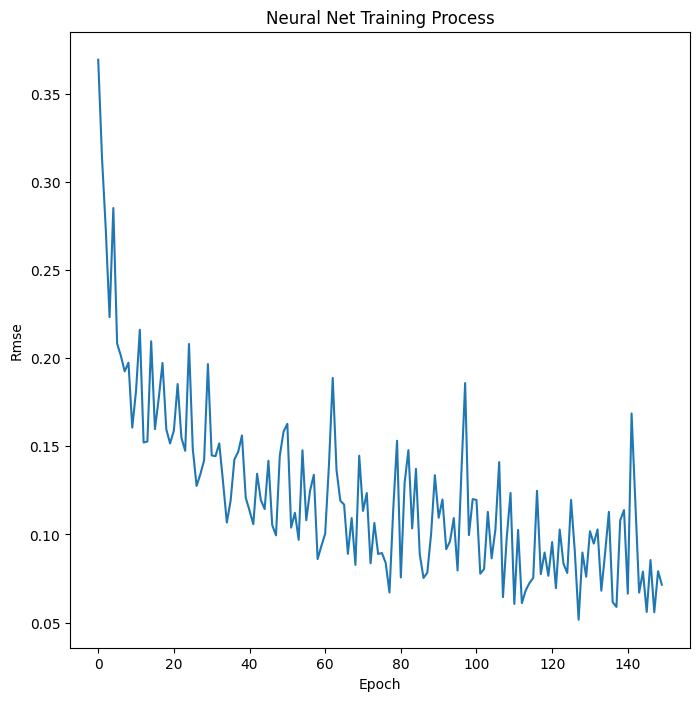

In [563]:
model_training(FCNN, train_tensor_dataloader, val_tensor_dataloader, 150)

In [564]:
FCNN.to('cpu')
FCNN.eval()

val_out = FCNN(torch.tensor(X_val))

mean_squared_error(y_val, val_out.detach().numpy())

0.05850521519191465

In [565]:
models_results['FCNN'] = mean_squared_error(y_val, val_out.detach().numpy())

### Results

In [566]:
models_results

linear_regression  gradient_boosting      FCNN
RMSE            0.61856           0.224281  0.058505

Полносвязная нейронная сеть показала наилучший результат. Проведем тестирование модели.

## Testing


Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

In [614]:
test_images.head()

image  \
0  3356748019_2251399314.jpg   
1  2887171449_f54a2b9f39.jpg   
2  3089107423_81a24eaf18.jpg   
3  1429546659_44cb09cbe2.jpg   
4  1177994172_10d143cb8d.jpg   

                                              vector  
0  [0.6528109, 0.6387547, 0.09824896, 0.24505779,...  
1  [0.28963217, 0.34629604, 1.3050839, 0.05714867...  
2  [0.010204707, 0.7312735, 0.26823097, 0.6412577...  
3  [0.20565389, 0.7177862, 0.8327788, 0.026637614...  
4  [0.06826933, 1.211225, 0.7042716, 0.04582752, ...

Преобразуем фото в векторы. Для этого напишем функцию

In [615]:
def test_images_to_vec(image_path):
  image = Image.open(TEST_IM_PATH + '/' + image_path).convert('RGB')
  image = transform(image)
  with torch.no_grad():
    image = resnet_model(image.to('cuda').unsqueeze(0))
  image = image.flatten().to('cpu')
  return image.numpy()

In [616]:
tqdm.pandas()
test_image_vectors = test_images['image'].progress_apply(test_images_to_vec)
test_image_vectors

100%|██████████| 100/100 [00:02<00:00, 43.93it/s]


0     [0.6528109, 0.6387547, 0.09824896, 0.24505779,...
1     [0.28963217, 0.34629604, 1.3050839, 0.05714867...
2     [0.010204707, 0.7312735, 0.26823097, 0.6412577...
3     [0.20565389, 0.7177862, 0.8327788, 0.026637614...
4     [0.06826933, 1.211225, 0.7042716, 0.04582752, ...
                            ...                        
95    [0.19748539, 0.7097712, 0.28096902, 0.31891903...
96    [1.0053996, 1.0327722, 1.1933779, 0.06320181, ...
97    [0.34538183, 0.75039923, 1.7617097, 0.00870572...
98    [0.31079915, 0.47419053, 1.0735494, 0.01596276...
99    [0.24625795, 0.36894244, 0.5249184, 0.7308684,...
Name: image, Length: 100, dtype: object

In [617]:
test_image_vectors.shape

(100,)

Соеденим все, что получилось в один датафрейм для более удобной работы

In [618]:
test_image_vectors = np.array(test_image_vectors)

In [619]:
test_image_vectors.shape

(100,)

In [620]:
test_images['vector'] = test_image_vectors
test_images.head()

image  \
0  3356748019_2251399314.jpg   
1  2887171449_f54a2b9f39.jpg   
2  3089107423_81a24eaf18.jpg   
3  1429546659_44cb09cbe2.jpg   
4  1177994172_10d143cb8d.jpg   

                                              vector  
0  [0.6528109, 0.6387547, 0.09824896, 0.24505779,...  
1  [0.28963217, 0.34629604, 1.3050839, 0.05714867...  
2  [0.010204707, 0.7312735, 0.26823097, 0.6412577...  
3  [0.20565389, 0.7177862, 0.8327788, 0.026637614...  
4  [0.06826933, 1.211225, 0.7042716, 0.04582752, ...

Теперь разберемся с запросами

In [621]:
test_queries.head()

query_id  \
11   123997871_6a9ca987b1.jpg#1   
13   123997871_6a9ca987b1.jpg#3   
14   123997871_6a9ca987b1.jpg#4   
15  1319634306_816f21677f.jpg#0   
16  1319634306_816f21677f.jpg#1   

                                           query_text  \
11  Several female lacrosse players are going afte...   
13  The woman lacrosse player in blue is about to ...   
14                              Women play lacrosse .   
15        A brown dog is sitting in some long grass .   
16             A brown dog sits still on a hillside .   

                        image  is_wrong  
11   123997871_6a9ca987b1.jpg         0  
13   123997871_6a9ca987b1.jpg         0  
14   123997871_6a9ca987b1.jpg         0  
15  1319634306_816f21677f.jpg         0  
16  1319634306_816f21677f.jpg         0

Выберем 10 из них и преобразем в векторы

In [629]:
ten_test_queries = test_queries.sample(10)
ten_test_queries

query_id  \
69   2121140070_a09644550b.jpg#4   
272  3211199368_ca78387f72.jpg#2   
164  2709359730_13bca100af.jpg#4   
306  3386953179_84c2d7922f.jpg#1   
240  3142055158_01b9e4caa4.jpg#0   
183  2887171449_f54a2b9f39.jpg#3   
226  3091962081_194f2f3bd4.jpg#1   
333  3435015880_eda46ff50f.jpg#3   
404  3601978895_9fec23ce0c.jpg#4   
126  2505465055_f1e6cf9b76.jpg#1   

                                            query_text  \
69      Men playing with a red ring out in the field .   
272  A dog is wearing jeans and a blue and yellow s...   
164  Two puppies jump from a concrete slab onto the...   
306  A snowboarder in a red jacket slides down a sn...   
240  A man playing rugby has the ball and tries to ...   
183  Woman in colorful shirt works at sewing machine .   
226  A man with glasses wearing all black sits on g...   
333  Two people jump up and down on a cliff overloo...   
404  Two men standing near a metal structure in fro...   
126                 A tan dog runs through the brush .   

                         image  is_wrong  
69   2121140070_a09644550b.jpg         0  
272  3211199368_ca78387f72.jpg         0  
164  2709359730_13bca100af.jpg         0  
306  3386953179_84c2d7922f.jpg         0  
240  3142055158_01b9e4caa4.jpg         0  
183  2887171449_f54a2b9f39.jpg         0  
226  3091962081_194f2f3bd4.jpg         0  
333  3435015880_eda46ff50f.jpg         0  
404  3601978895_9fec23ce0c.jpg         0  
126  2505465055_f1e6cf9b76.jpg         0

In [623]:
tokenized_test_texts = ten_test_queries['query_text'].progress_apply(tokenizer, truncation=True,
                          padding="max_length",
                          max_length=25,
                          return_tensors="pt").values

100%|██████████| 10/10 [00:00<00:00, 1196.90it/s]


In [624]:
with torch.no_grad():
  torch.cuda.empty_cache()
  test_query_vectors = np.array([bert_model(**tokenized_test_texts[i].to('cuda')) for i in tqdm(range(len(tokenized_test_texts)))])

100%|██████████| 10/10 [00:00<00:00, 55.03it/s]


In [625]:
test_query = np.array([test_query_vectors[i][1].flatten().to('cpu').detach().numpy() for i in range(len(test_query_vectors))])
test_query.shape

(10, 768)

Напишем фукнцию для поиска наиболее релевантного изображения

In [626]:
def find_image(query, test_images):

  result = {}

  tokenized_query = tokenizer(query, truncation=True,
                          padding="max_length",
                          max_length=25,
                          return_tensors="pt")
  with torch.no_grad():
    torch.cuda.empty_cache()
    tokenized_query = bert_model(**tokenized_query.to('cuda'))

  text_vector = tokenized_query[1].flatten().to('cpu').detach().numpy()

  for i in range(len(test_images)):

    image_vec = test_images['vector'][i]
    image_path = test_images['image'][i]

    X_vec = np.concatenate((text_vector, image_vec))
    X_vec = X_vec.reshape(1, -1)

    with torch.no_grad():
      FCNN.eval()
      result[image_path] = FCNN(torch.tensor(X_vec)).numpy()[0][0]

  result = sorted(result.items(), key=lambda x:x[1], reverse=True)

  best_image = Image.open(TEST_IM_PATH + '/' + result[0][0])
  best_image.show()
  print(result[0][1])
  print(query)

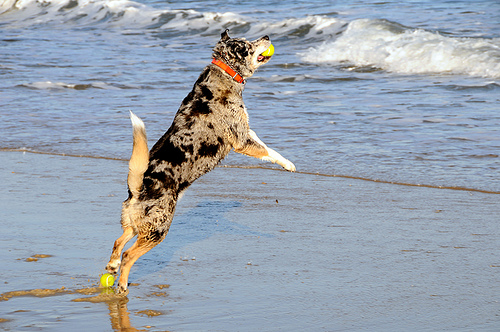

0.59703326
Men playing with a red ring out in the field .


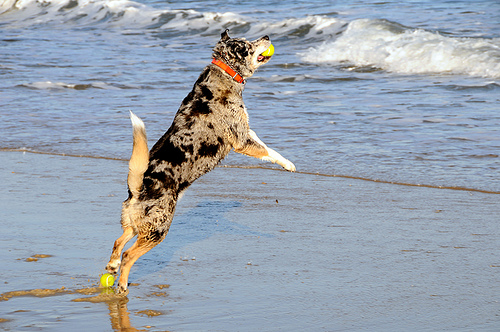

0.47703657
A dog is wearing jeans and a blue and yellow shirt with a black vehicle in the background .


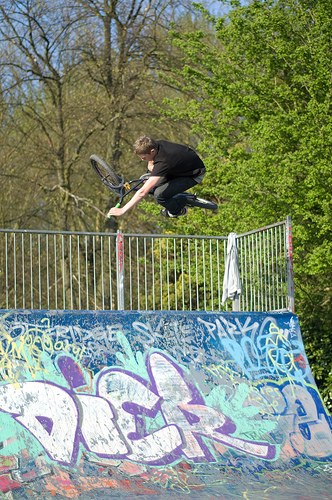

0.6036234
Two puppies jump from a concrete slab onto the grass .


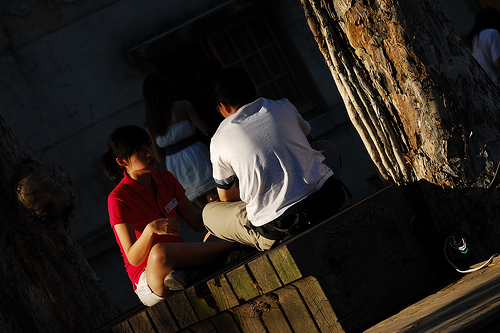

0.6794093
A snowboarder in a red jacket slides down a snowy mountain .


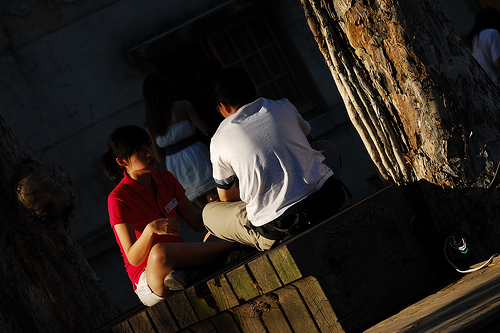

0.58844507
A man playing rugby has the ball and tries to evade a tackler .


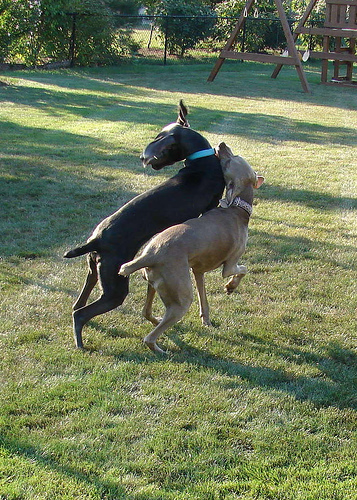

0.87418616
Woman in colorful shirt works at sewing machine .


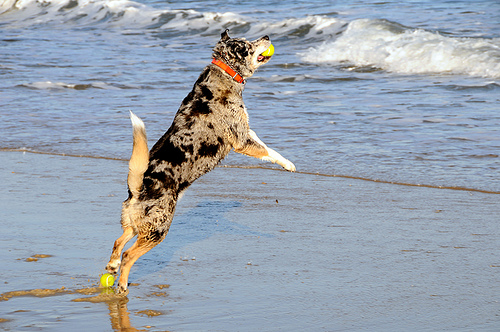

0.49589187
A man with glasses wearing all black sits on grass surrounded by other people .


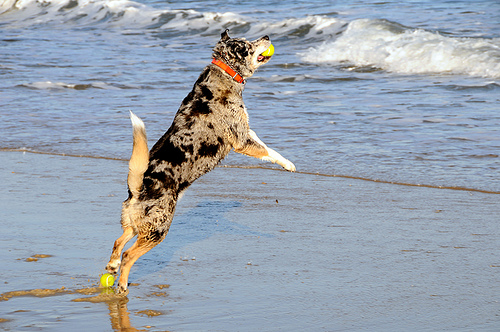

0.47074625
Two people jump up and down on a cliff overlooking a valley .


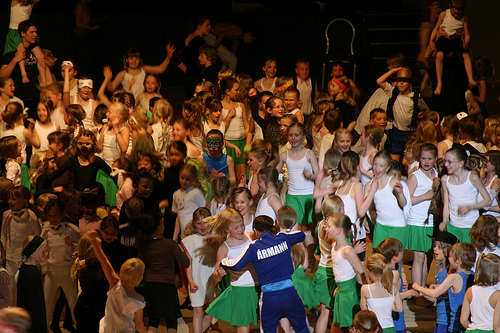

0.51024175
Two men standing near a metal structure in from of a brick wall .


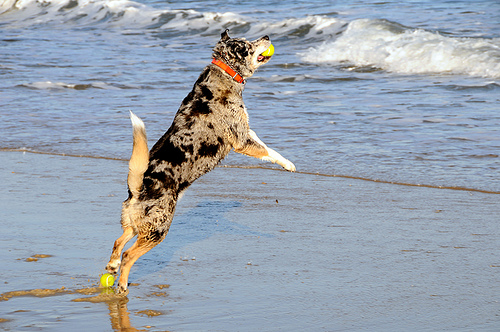

0.80253476
A tan dog runs through the brush .


In [630]:
for i in ten_test_queries.index:
   find_image(ten_test_queries['query_text'][i], test_images)

Тестирование показало, что работа нашей модели не столь результативна. Очевидно, что есть какие-то картинки, которым модель отдает большее предпочтение.

При поиске вохможных ошибок в коде или работе с данными мне не удалось найти существенных причин, из-за которых модель на тесте так сильно ошибается.